## Import Modules

In [55]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import cv2
import random
import tensorflow as tf
# from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import seaborn
from tkinter import *
from tkinter import filedialog

### Organize the Images

In [2]:
input_path = []
label = []

for class_name in os.listdir("dataset"):
    for path in os.listdir(f"dataset/{class_name}"):
        if class_name == 'Cat':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join("dataset", class_name, path))
print(input_path[0], label[0])

dataset\Cat\0.jpg 0


### Create A DataFrame From Image Data

In [43]:
df = pd.DataFrame()
df["ImagePath"] = input_path
df["Class"] = label
df = df.sample(frac=1).reset_index(drop=True)
# df["Class"] = df["Class"].astype('str')
df.head()

,ImagePath,Class
0,dataset\Cat\8877.jpg,0
1,dataset\Dog\6847.jpg,1
2,dataset\Cat\1049.jpg,0
3,dataset\Dog\8637.jpg,1
4,dataset\Dog\10444.jpg,1


### Show A Visual of Data Count

<Axes: xlabel='Class', ylabel='count'>

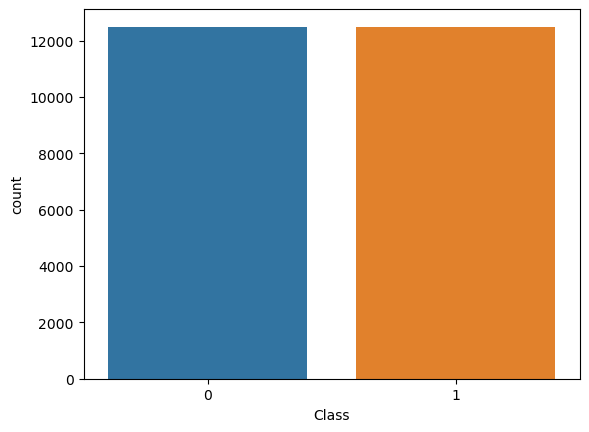

In [56]:
seaborn.countplot(df, x=df["Class"])

### Show a few Examples of the Dataset

In [4]:
main_dir = "dataset"
cats = "Cat"
dogs = "Dog"
path_cats = os.path.join(main_dir, cats)
path_dogs = os.path.join(main_dir, dogs)
images_cats = os.listdir(path_cats)
images_dogs = os.listdir(path_dogs)
plt.figure(figsize=(25, 25))

<Figure size 2500x2500 with 0 Axes>

<Figure size 2500x2500 with 0 Axes>

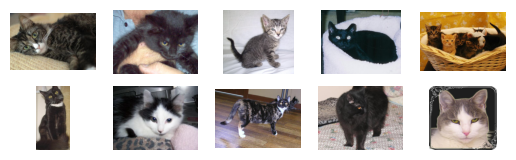

In [5]:
# Show sample of cat images
for i in range(10):
   img = random.choice([x for x in images_cats])
   fig = plt.subplot(5, 5, i + 1)
   img = mpimg.imread(os.path.join(path_cats, img))
   fig.imshow(img)
   fig.axis("off")

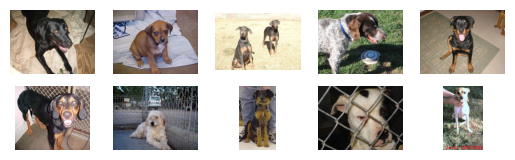

In [6]:
# Show sample of dog images
for i in range(10):
   img = random.choice([x for x in images_dogs])
   fig = plt.subplot(5, 5, i + 1)
   img = mpimg.imread(os.path.join(path_dogs, img))
   fig.imshow(img)
   fig.axis("off")

### Create DataGenerators for the Images

In [7]:
# Input split
train, test = train_test_split(df, test_size=0.2, random_state=42)

train_generator = ImageDataGenerator(rescale = 1./255)
val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(train,
                                                     x_col="ImagePath",
                                                     y_col="Class",
                                                    target_size=(128, 128),
                                                    batch_size=512,
                                                    class_mode="binary")

val_iterator = val_generator.flow_from_dataframe(test,
                                                 x_col="ImagePath",
                                                 y_col="Class",
                                                 target_size=(128, 128),
                                                 batch_size=512,
                                                 class_mode="binary")

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


### Build CNN

In [8]:
def build_cnn():
    model = Sequential()
    
    # Adds a densly-connected layer to the model
    model.add(Conv2D(16, (3, 3), activation="relu", input_shape=(128, 128, 3)))
    model.add(MaxPool2D((2, 2)))

    # Add another layer
    model.add(Conv2D(32, (3, 3), activation="relu"))
    model.add(MaxPool2D((2, 2)))

    # And another layer
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPool2D((2, 2)))

    # Guess what..? Add another layer
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPool2D((2, 2)))

    # Flatten, then feed the data to the Dense layer
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    
    return model
    
model = build_cnn()

### Complie the model

In [9]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0

### Fit Model with Training Data, Validating Against the Test Data

In [10]:
history = model.fit(train_iterator, epochs=20, validation_data=val_iterator)

Epoch 1/20
29/40 [====================>.........] - ETA: 41s - loss: 0.7029 - accuracy: 0.5285

C:\Users\jzwei\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


40/40 [==============================] - 182s 5s/step - loss: 0.6895 - accuracy: 0.5525 - val_loss: 0.6388 - val_accuracy: 0.6276
Epoch 2/20
40/40 [==============================] - 97s 2s/step - loss: 0.6429 - accuracy: 0.6231 - val_loss: 0.5983 - val_accuracy: 0.6592
Epoch 3/20
40/40 [==============================] - 96s 2s/step - loss: 0.5708 - accuracy: 0.6985 - val_loss: 0.5348 - val_accuracy: 0.7284
Epoch 4/20
40/40 [==============================] - 99s 2s/step - loss: 0.5175 - accuracy: 0.7430 - val_loss: 0.5129 - val_accuracy: 0.7530
Epoch 5/20
40/40 [==============================] - 97s 2s/step - loss: 0.4861 - accuracy: 0.7663 - val_loss: 0.4722 - val_accuracy: 0.7700
Epoch 6/20
40/40 [==============================] - 97s 2s/step - loss: 0.4614 - accuracy: 0.7807 - val_loss: 0.4578 - val_accuracy: 0.7838
Epoch 7/20
40/40 [==============================] - 96s 2s/step - loss: 0.4154 - accuracy: 0.8118 - val_loss: 0.4135 - val_accuracy: 0.8086
Epoch 8/20
40/40 [============

### Data Model Persistence

In [11]:
# dump(model, "model.joblib")
model.save("dog_cat_classifier.model")

INFO:tensorflow:Assets written to: dog_cat_classifier.model\assets


INFO:tensorflow:Assets written to: dog_cat_classifier.model\assets


### Reload Data Model

In [3]:
# model = load("model.joblib")
model = keras.models.load_model("dog_cat_classifier.model")

OSError: Cannot parse keras metadata at path dog_cat_classifier.model\keras_metadata.pb: Received error: Error parsing message

### Make Visualization of Accuracy Results

In [12]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))

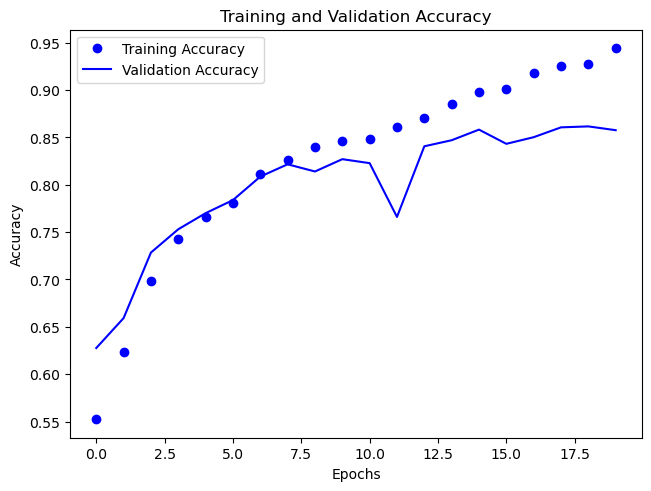

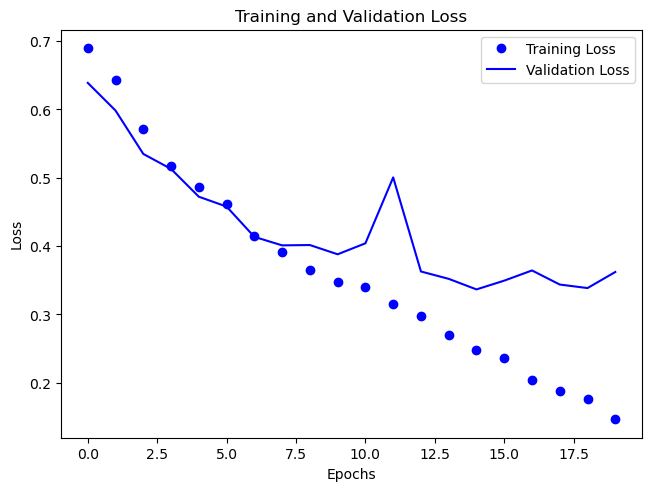

In [13]:
fig_1, ax_1 = plt.subplots(layout="constrained")
ax_1.plot(epochs, acc, "bo", label="Training Accuracy")
ax_1.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax_1.set_title("Training and Validation Accuracy")
ax_1.set_xlabel("Epochs")
ax_1.set_ylabel("Accuracy")
ax_1.legend()

fig_2, ax_2 = plt.subplots(layout="constrained")
ax_2.plot(epochs, loss, "bo", label="Training Loss")
ax_2.plot(epochs, val_loss, "b", label="Validation Loss")
ax_2.set_title("Training and Validation Loss")
ax_2.set_xlabel("Epochs")
ax_2.set_ylabel("Loss")
ax_2.legend()

## Notebook Interactivity

### Have User Select a Cat or Dog Image

In [28]:
filepath = Tk().filename = filedialog.askopenfilename(title="Select A File", filetypes=(("Jpg files", "*.jpg"), ("All Files", "*.*")))
Tk().mainloop()

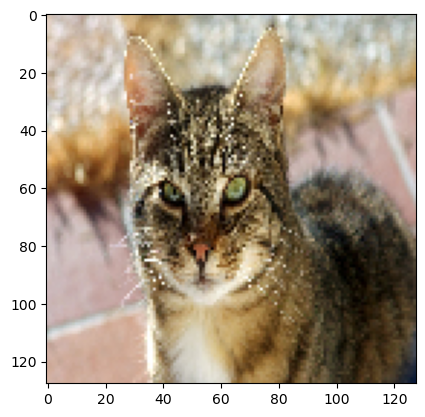

In [29]:
img = load_img(filepath, target_size=(128, 128))
plt.imshow(img, cmap=plt.cm.binary)

### Re-scale Selected Image

In [30]:
# resized_img_array = cv2.resize(img_array, dsize=(80, 80))
# plt.imshow(resized_img_array, cmap=plt.cm.binary)
img = np.array(img)
img = img / 255.0
img = img.reshape(1, 128, 128, 3)

### Make Prediction

In [31]:
# test = []
# test = np.array([resized_img_array]).reshape(-1, 80, 80, 3)
# test = test / 255
# prediction = model.predict(test)
prediction = model.predict(img)

1/1 [==============================] - 0s 23ms/step


In [32]:
# index = np.argmax(prediction)
# class_name = class_names[round(int(prediction))]
# print(int(prediction))
if prediction[0] > 0.5:
    class_name = "dog"
else:
    class_name = "cat"

In [33]:
if class_name == "cat":
    print("We have detected that the photo of your furry friend is a cat.")
    print("We want to warn you that Doggie Consumables' medicinal treats are intended for dogs only.")
    print("Please, buy with caution.")
else:
    print("We hope your puppy enjoys his/her new treats!!")

We have detected that the photo of your furry friend is a cat.
We want to warn you that Doggie Consumables' medicinal treats are intended for dogs only.
Please, buy with caution.
